
### 1. Introduction to Graph Convolutional Networks (GCNs)

- **Definition**: Graph Convolutional Networks (GCNs) are specialized neural networks designed to work with graph-structured data.
- **Core Idea**: GCNs generalize traditional convolutions (used in CNNs for images) to graphs. Instead of processing pixels in a grid, GCNs operate on nodes in a graph and use the structure to propagate information.
- **Applications**: GCNs are widely used in social networks, recommendation systems, natural language processing, and more.



### 2. Message Passing Mechanism

- **Message Passing**: GCNs utilize a message-passing framework, where each node updates its features by aggregating information from its neighbors.
- **Feature Aggregation**:
  - Each node receives information from its connected neighbors.
  - The node aggregates these incoming “messages” and updates its feature representation.
- **Aggregation Methods**:
  - **Sum**: The simplest and commonly used aggregation function.
  - **Mean**: Average of neighbors’ features.
  - **Max**: Maximum value among neighbors’ features.

**Example of Message Passing**:
   - Consider a graph with nodes \( A \), \( B \), and \( C \) where \( A \) is connected to both \( B \) and \( C \).
   - If \( A \) has a feature value \( f_A \), it will aggregate the features of \( B \) and \( C \) (say, \( f_B \) and \( f_C \)) to update its own feature.


Explanation:

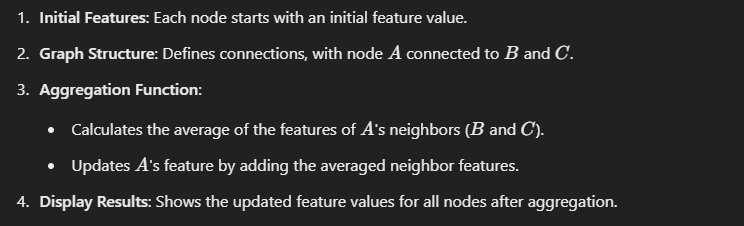

In [7]:
# Define initial features for each node
features = {
    "A": 1.0,  # Initial feature value for node A
    "B": 2.0,  # Initial feature value for node B
    "C": 3.0   # Initial feature value for node C
}

# Define a graph structure
graph = {
    "A": ["B", "C"],  # Node A is connected to both B and C
    "B": [],  # Node B has no outgoing edges in this example
    "C": []   # Node C has no outgoing edges in this example
}

print("Initial Features:")
for node, feature in features.items():
    print(f"Node {node}: Feature Value = {feature}")

print("\nGraph Structure:")
for node, neighbors in graph.items():
    print(f"Node {node} is connected to: {neighbors}")


# Aggregation function: updating node A by averaging features of connected nodes (B and C)
def aggregate_features(node, graph, features):
    neighbors = graph[node]  # Get the neighbors connected to the node
    if not neighbors:
        return features[node]  # Return original feature if there are no neighbors

    # Sum the feature values of neighbors and take the average
    aggregated_feature = sum(features[neighbor] for neighbor in neighbors) / len(neighbors) # 2+3 = 5; 5/2 =2.5
    print(f"Aggregated Feature for Node {node}: {aggregated_feature}")
    # Update the feature for node A based on the aggregated value
    updated_feature = features[node] + aggregated_feature
    print(f"Updated Feature for Node {node}: {updated_feature}")
    return updated_feature

# Update the feature for node A by aggregating the features of nodes B and C
updated_feature_A = aggregate_features("A", graph, features)
features["A"] = updated_feature_A  # Assign the new feature value to node A

# Display updated features
print("Updated Features:")
for node, feature in features.items():
    print(f"Node {node}: Feature Value = {feature}")


Initial Features:
Node A: Feature Value = 1.0
Node B: Feature Value = 2.0
Node C: Feature Value = 3.0

Graph Structure:
Node A is connected to: ['B', 'C']
Node B is connected to: []
Node C is connected to: []
Aggregated Feature for Node A: 2.5
Updated Feature for Node A: 3.5
Updated Features:
Node A: Feature Value = 3.5
Node B: Feature Value = 2.0
Node C: Feature Value = 3.0


Graphical Representation of the above graph after aggregation

['A', 'B', 'C']
[]
[('A', 'B'), ('A', 'C')]


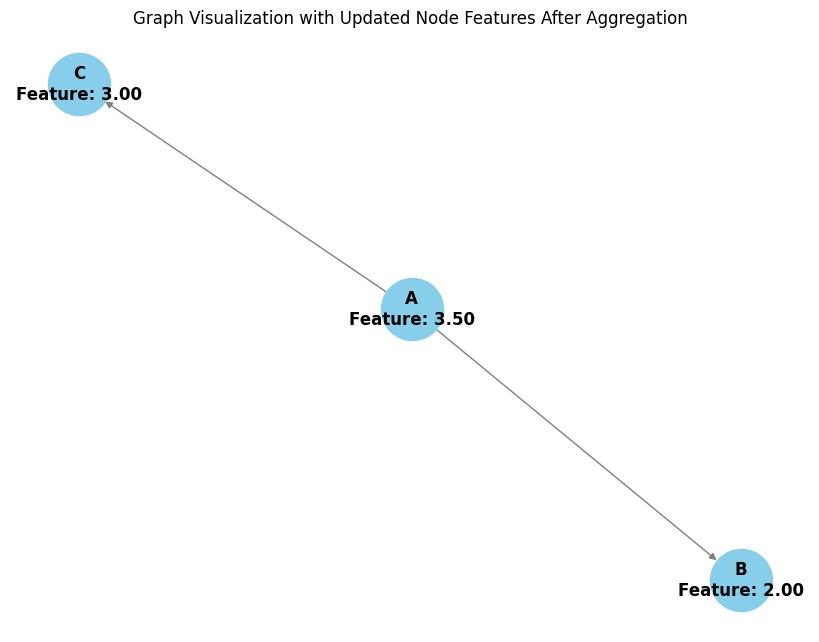

In [13]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph for visualization
G = nx.DiGraph()

# Add nodes with labels showing the updated feature values
for node, feature in features.items():
    G.add_node(node, label=f"{node}\nFeature: {feature:.2f}")

print(G.nodes)
print(G.edges)

# Add edges based on the graph structure
for node, neighbors in graph.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

print(G.edges)
# Set up node positions and labels
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'label')

# Draw nodes with updated feature values and edges
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight="bold")

# Add a title for context
plt.title("Graph Visualization with Updated Node Features After Aggregation")
plt.show()



### 3. Implementing the GCN Layer

The GCN layer is essentially a **linear transformation** followed by **message aggregation**.

1. **Linear Transformation**:
   - A weight matrix is applied to each node’s feature vector, transforming the input features.
2. **Neighborhood Aggregation**:
   - The transformed feature of each node is updated based on the features of its neighbors.
3. **Normalization**:
   - Normalization is applied to ensure that feature propagation is balanced, regardless of the node’s degree (number of neighbors).



#### GCN Layer Equation

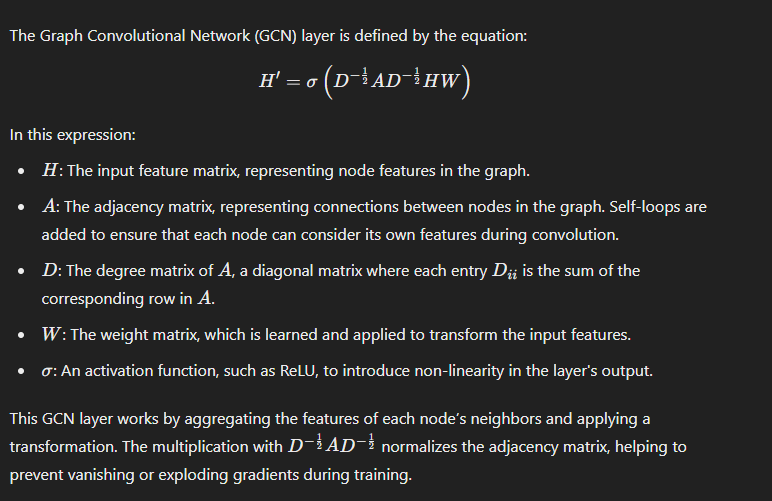


### 4. Code Walkthrough

Here’s a step-by-step implementation of a simple GCN layer in PyTorch.



In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Initialize a Graph Convolutional Network (GCN) layer.

        Parameters:
        - in_features: Number of input features per node (e.g., feature dimension).
        - out_features: Number of output features per node (e.g., transformed feature dimension).
        """
        super(GCNLayer, self).__init__()

        # Define a linear transformation (weights) for feature transformation
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, node_features, adj_matrix):
        """
        Forward pass for the GCN layer.

        Parameters:
        - node_features: Tensor of shape [num_nodes, in_features] containing the initial features of each node.
        - adj_matrix: Tensor of shape [num_nodes, num_nodes] representing the adjacency matrix of the graph,
                      where adj_matrix[i][j] is 1 if there is an edge from node i to node j, else 0.

        Returns:
        - Updated node features of shape [num_nodes, out_features] after aggregation and transformation.
        """
        # Step 1: Linear transformation of node features
        # Apply a learned linear transformation to each node's features to project to the output feature space
        transformed_features = self.linear(node_features)

        # Step 2: Message Passing
        # Aggregate information from neighboring nodes by matrix-multiplying the adjacency matrix
        # with the transformed features. This computes a weighted sum of neighboring features for each node.
        aggregated_features = torch.matmul(adj_matrix, transformed_features)

        # Step 3: Normalization by Node Degrees
        # Normalize the aggregated features by the degree of each node to maintain scale
        # and prevent nodes with many connections from having disproportionately high values.
        # The degree of a node is the sum of the entries in its row in the adjacency matrix.
        degrees = adj_matrix.sum(dim=1, keepdim=True)  # Compute the degree of each node
        normalized_features = aggregated_features / degrees  # Normalize by dividing aggregated values by degree

        # Step 4: Apply Activation Function
        # Use ReLU activation to introduce non-linearity, which helps the model capture complex relationships.
        return F.relu(normalized_features)



### 5. Testing the GCN Layer with a Sample Graph

Let’s create a simple graph and test the GCN layer to see how it updates node features.



#### Step 1: Define the Graph Structure

- Define an adjacency matrix for a 3-node graph with the following connections:
  - Node 0 is connected to Node 1.
  - Node 1 is connected to Node 2.
  - Node 2 is connected back to Node 0.



In [16]:
import torch

# Sample graph adjacency matrix with self-loops added
# Each row represents a node, and a value of 1 indicates an edge (or self-loop) between nodes
adj_matrix = torch.tensor([
    [1, 1, 0],  # Node 0 is connected to Node 1 and has a self-loop
    [1, 1, 1],  # Node 1 is connected to Nodes 0, 1 (self-loop), and 2
    [0, 1, 1]   # Node 2 is connected to Node 1 and has a self-loop
], dtype=torch.float32)

# Print the adjacency matrix to verify its structure
print("Adjacency Matrix (with self-loops):")
print(adj_matrix)

# Node features for a graph with 3 nodes, where each node has a feature vector of dimension 2
# This tensor holds initial feature values for each node in the graph
node_features = torch.tensor([
    [1.0, 2.0],  # Feature vector for Node 0
    [2.0, 3.0],  # Feature vector for Node 1
    [3.0, 4.0]   # Feature vector for Node 2
], dtype=torch.float32)

# Print the node features to confirm initial values
print("\nInitial Node Features:")
print(node_features)


Adjacency Matrix (with self-loops):
tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])

Initial Node Features:
tensor([[1., 2.],
        [2., 3.],
        [3., 4.]])


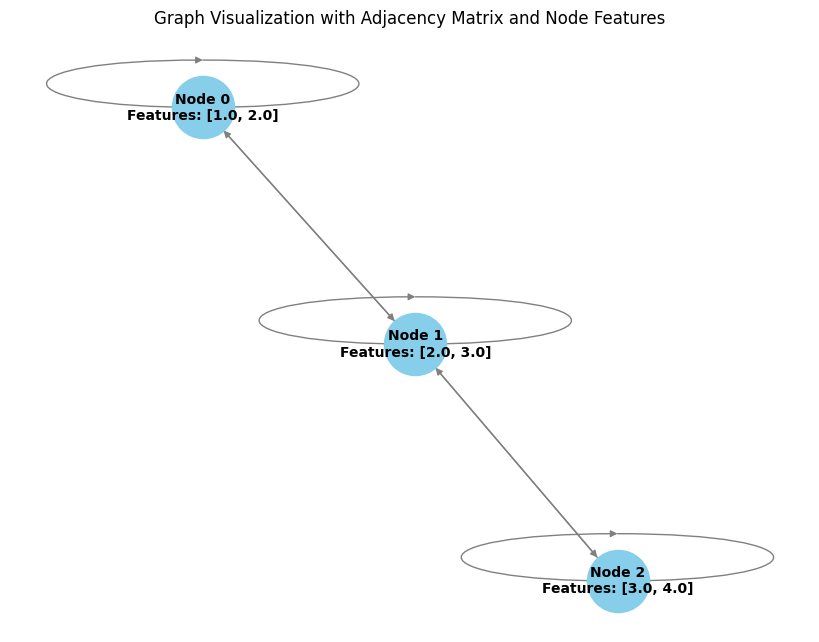

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Initialize a directed graph with NetworkX
G = nx.DiGraph()

# Add nodes to the graph with feature information in the label
for i in range(node_features.shape[0]):
    G.add_node(i, label=f"Node {i}\nFeatures: {node_features[i].tolist()}")

# Add edges based on the adjacency matrix
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] == 1:
            G.add_edge(i, j)

# Define node positions with a spring layout for clear visualization
pos = nx.spring_layout(G)

# Draw the graph nodes with labels (features included)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10, font_weight="bold")

# Add a title for context
plt.title("Graph Visualization with Adjacency Matrix and Node Features")
plt.show()



#### Step 2: Initialize and Run the GCN Layer



Example - 1

In [21]:
# Initialize the GCN layer with input and output feature dimensions
# - in_features=: Each node has an initial feature vector of dimension 2
# - out_features=8: The GCN layer will output a transformed feature vector of dimension 2 for each node
gcn_layer = GCNLayer(in_features=2, out_features=8)

# Perform a forward pass through the GCN layer
# - node_features: Initial features for each node
# - adj_matrix: Adjacency matrix of the graph
updated_features = gcn_layer(node_features, adj_matrix)

# Display the updated node features after passing through the GCN layer
print("Updated Node Features after GCN Layer:")
print(updated_features)


Updated Node Features after GCN Layer:
tensor([[0.0000, 0.0000, 1.3320, 0.0252, 0.0000, 0.8701, 0.0000, 1.3949],
        [0.0000, 0.0000, 1.5504, 0.0000, 0.0000, 0.9524, 0.0000, 1.6836],
        [0.0000, 0.0000, 1.7688, 0.0000, 0.0000, 1.0348, 0.0000, 1.9724]],
       grad_fn=<ReluBackward0>)


Example - 2

In [22]:
# Initialize the GCN layer with input and output feature dimensions
# - in_features=2: Each node has an initial feature vector of dimension 2
# - out_features=2: The GCN layer will output a transformed feature vector of dimension 2 for each node
gcn_layer = GCNLayer(in_features=2, out_features=2)

# Perform a forward pass through the GCN layer
# - node_features: Initial features for each node
# - adj_matrix: Adjacency matrix of the graph
updated_features = gcn_layer(node_features, adj_matrix)

# Display the updated node features after passing through the GCN layer
print("Updated Node Features after GCN Layer:")
print(updated_features)


Updated Node Features after GCN Layer:
tensor([[1.3100, 1.2626],
        [1.6632, 1.5006],
        [2.0164, 1.7387]], grad_fn=<ReluBackward0>)


Visualized Output

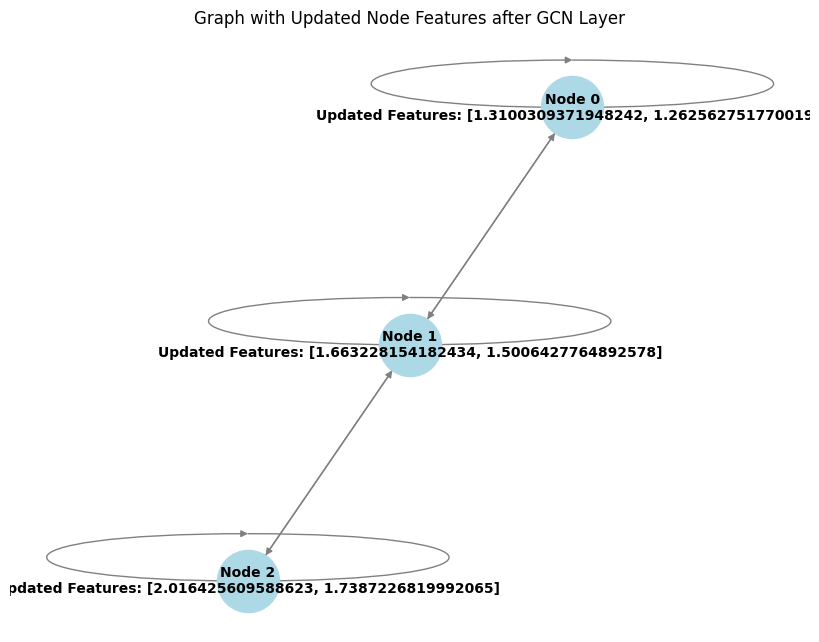

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Forward pass to obtain updated features
updated_features = gcn_layer(node_features, adj_matrix)

# Initialize a directed graph for visualization
G = nx.DiGraph()

# Add nodes with updated feature values
for i in range(updated_features.shape[0]):
    # Convert updated features to a list for display
    feature_values = updated_features[i].detach().numpy().tolist()
    G.add_node(i, label=f"Node {i}\nUpdated Features: {feature_values}")

# Add edges based on the adjacency matrix
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] == 1:
            G.add_edge(i, j)

# Define node positions for clear visualization
pos = nx.spring_layout(G)

# Draw the graph with updated feature labels
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10, font_weight="bold")

# Add a title for clarity
plt.title("Graph with Updated Node Features after GCN Layer")
plt.show()



#### Explanation of Output
- Each node’s feature is updated based on its own initial feature and the features of its connected neighbors.
- The normalization step ensures that nodes with more connections don’t disproportionately influence the feature propagation.



### 6. Observations and Key Takeaways

- **Effect of Self-Loops**:
  - Adding self-loops (connecting nodes to themselves) is common in GCNs.
  - Self-loops allow each node to retain a portion of its original feature, which stabilizes feature updates.

- **Normalization**:
  - The normalization step prevents nodes with higher degrees from overly dominating the feature aggregation.
  - It also ensures balanced feature propagation across nodes.

- **Information Propagation**:
  - GCNs work by allowing each node to learn from its immediate neighbors.
  - Stacking multiple GCN layers enables nodes to gather information from farther nodes, expanding the receptive field.



### Code Observations

- The **linear transformation** step with `self.linear(node_features)` updates the feature space, allowing nodes to learn different representations.
- **Matrix multiplication** with the adjacency matrix aggregates features from neighboring nodes.
- **Division by degree** balances the influence of each node’s neighbors.

---



### Summary

In this section, we have implemented a basic GCN layer and demonstrated how it updates node features based on the graph’s adjacency matrix. The GCN layer combines linear transformations, neighborhood aggregation, and normalization, making it well-suited for handling graph-structured data.

This foundational layer is a building block for more complex GCN architectures.